In [5]:
# import data_loading

import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt

## Hyperparameters

In [6]:
image_size = 240
channels = 4
# channels = 1

## Sequence data generator

In [7]:
class SequenceDataGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, file_path='../dataset/', mode='training', glioma_type='HGG'):
        self.dir_paths = []
        for directory in os.listdir(file_path + mode + "/" + glioma_type):
            self.dir_paths.append(os.path.join(file_path, mode, glioma_type, directory))
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.dir_paths) / float(self.batch_size)))
    
    def __get_image_array__(self, file_path):
            return sitka.GetArrayFromImage(sitka.ReadImage(file_path, sitka.sitkFloat32))
    
    def __get_mask_and_slice_position__(self, dir_path):

        mask_file_name = dir_path[dir_path.rfind('\\') + 1:] + "_seg.nii.gz"
        img = self.__get_image_array__(os.path.join(dir_path, mask_file_name))
        slice_position = random.randint(20, 120)
        while True:
            mask = img[slice_position, :, :]
            if mask.max() > 0:
                return mask, slice_position
            else:
                slice_position = (slice_position + 1) % 150
    
    def __normalise__(self, tensor):
        for idx_channel, channel in enumerate(tensor):
            b_rows, b_cols = np.nonzero(channel.astype(bool))
            brain = channel[b_rows, b_cols]
            b_mean = brain.mean()
            b_std = brain.std()
            brain = (brain - b_mean) / b_std

            channel = np.zeros((image_size, image_size)) # Reset background
            for idx,coords in enumerate(zip(b_rows, b_cols)):
                y, x = coords
                channel[y, x] = brain[idx]
            
            tensor[idx_channel] = channel
            
        return tensor
    
    def __load__(self, dir_path):

        ### 
        tensor = np.zeros((240, 240))        
        mask, slice_position = self.__get_mask_and_slice_position__(dir_path)
        
        for file in os.listdir(dir_path):
            img = self.__get_image_array__(os.path.join(dir_path, file))
            if file.find('seg') == -1:
                tensor = np.dstack((tensor, img[slice_position, :, :]))
        
        tensor, mask = tensor.swapaxes(0, 2)[1:, :, :], mask.swapaxes(0, 1)
        
        tensor = self.__normalise__(tensor)
            
        return tensor, mask

    def __getitem__(self, idx):
        batch_x = self.dir_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        masks = []
        
        for dir_path in batch_x:
            image_, mask_ = self.__load__(dir_path)
            images.append(image_)
#             images.append([image_[3]])
            masks.append([mask_])
        
        return np.array(images), np.array(masks)

In [8]:
gen = SequenceDataGenerator(batch_size=1, mode="training")
x, y = gen.__getitem__(2)
print(x.shape, y.shape)

(1, 4, 240, 240) (1, 1, 240, 240)


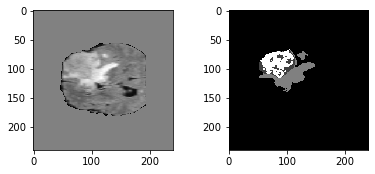

In [9]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[0][0], cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y, (image_size, image_size)), cmap="gray")

In [357]:
def conv_relu_block(input_tensor, num_of_filters):

    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(input_tensor)
    conv_relu = keras.layers.Conv2D(activation='relu',
                                    filters=num_of_filters,
                                    kernel_size=(3, 3),
                                    strides=1,
                                    padding='same',
                                    data_format='channels_first')(conv_relu)

    return conv_relu



In [358]:
def max_pool(input_tensor):
    return keras.layers.MaxPooling2D(pool_size=(2, 2),
                                     strides=None,
                                     padding='same',
                                     data_format='channels_first')(input_tensor)



In [359]:
def up_sample(input_tensor, encode_input_tensor):
    us = keras.layers.UpSampling2D(size=(2, 2),
                                   data_format='channels_first')(input_tensor)
    concat = keras.layers.Concatenate(axis=1)(inputs=[us, encode_input_tensor])
    return concat



In [360]:
def UNet():

    filters = [1, 64, 128, 256, 512, 1024]

    input_data = keras.layers.Input(shape=(channels, image_size, image_size))
    
    print(input_data.shape)

    # encode
    cr1 = conv_relu_block(input_data, filters[1])
    md1 = max_pool(cr1)
    cr2 = conv_relu_block(md1, filters[2])
    md2 = max_pool(cr2)
    cr3 = conv_relu_block(md2, filters[3])
    md3 = max_pool(cr3)
    cr4 = conv_relu_block(md3, filters[4])
    md4 = max_pool(cr4)

    # bottom
    cr5 = conv_relu_block(md4, filters[5])

    # decode
    us1 = up_sample(cr5, cr4)
    cr6 = conv_relu_block(us1, filters[4])
    us2 = up_sample(cr6, cr3)
    cr7 = conv_relu_block(us2, filters[3])
    us3 = up_sample(cr7, cr2)
    cr8 = conv_relu_block(us3, filters[2])
    us4 = up_sample(cr8, cr1)
    cr9 = conv_relu_block(us4, filters[1])

    output_data = keras.layers.Conv2D(filters=filters[0],
                                      kernel_size=(1, 1),
                                      padding="same",
                                      activation="sigmoid",
                                      data_format='channels_first')(cr9)

    model = keras.models.Model(input_data,
                               output_data,
                               name="UNet")

    return model

In [419]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [501]:
model = UNet()
model.compile(optimizer="adam",
              loss="binary_crossentropy",
#               loss="mean_squared_error",
#               loss=jaccard_distance_loss,
              metrics=["accuracy"]
             )



(None, 4, 240, 240)


In [502]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)
        if current < 0:
            if self.verbose > 0:
                print("Training stopped for negative loss at", epoch + 1)
            self.model.stop_training = True
        if current < self.value:
            if self.verbose > 0:
                print("Training stopped early at", epoch + 1)
            self.model.stop_training = True

callbacks = [
#     EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
    keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.5, patience=1, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
]

In [503]:
number_of_hgg_samples = 239
batch_size = 5
epochs = 5

train_gen = SequenceDataGenerator(batch_size=batch_size, mode="training")
valid_gen = SequenceDataGenerator(batch_size=batch_size, mode="validation")

train_steps = number_of_hgg_samples//batch_size
valid_steps = 20//batch_size

print(train_steps)

hist = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, shuffle=True, callbacks=callbacks)

47
Epoch 1/5
47/47 [==============================] - 168s 4s/step - loss: 2.4023 - accuracy: 0.9462 - val_loss: 3.9109 - val_accuracy: 0.9737
Epoch 2/5
47/47 [==============================] - 167s 4s/step - loss: -0.2985 - accuracy: 0.9711 - val_loss: -1.5994 - val_accuracy: 0.9533
Epoch 3/5
 1/47 [..............................] - ETA: 2:33 - loss: -0.2220 - accuracy: 0.9576

KeyboardInterrupt: 

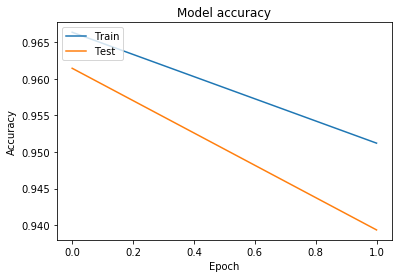

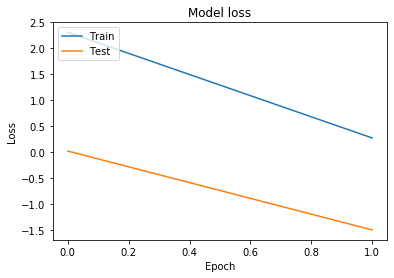

In [451]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [488]:
x, y = gen.__getitem__(random.randint(0, 10))
pred = model.predict(x)

In [494]:
for i in y:
    for j in i:
        for k in j:
            print(k)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [495]:
for i in pred:
    for j in i:
        for k in j:
            print(k)

[5.98540120e-02 7.99048971e-03 1.86050485e-03 8.45529372e-04
 3.86725180e-04 2.59587046e-04 1.72232438e-04 1.36301998e-04
 1.03682934e-04 8.81695523e-05 7.37639712e-05 6.61841696e-05
 5.79011285e-05 5.32739541e-05 4.83118129e-05 4.53746252e-05
 4.19593307e-05 3.99832716e-05 3.78388795e-05 3.65982305e-05
 3.51692106e-05 3.43446227e-05 3.34359866e-05 3.28872557e-05
 3.22241285e-05 3.18278253e-05 3.13823366e-05 3.11140793e-05
 3.07879563e-05 3.05869653e-05 3.03497800e-05 3.01937453e-05
 2.99940039e-05 2.98658179e-05 2.97142287e-05 2.96178441e-05
 2.94992533e-05 2.94256388e-05 2.93392786e-05 2.92837394e-05
 2.92138666e-05 2.91699926e-05 2.91180186e-05 2.90844109e-05
 2.90412318e-05 2.90127191e-05 2.89767177e-05 2.89511936e-05
 2.89169238e-05 2.88933843e-05 2.88634201e-05 2.88422325e-05
 2.88136143e-05 2.87935891e-05 2.87670227e-05 2.87473031e-05
 2.87198745e-05 2.87003531e-05 2.86740378e-05 2.86542436e-05
 2.86260856e-05 2.86054001e-05 2.85768001e-05 2.85547903e-05
 2.85237093e-05 2.850135

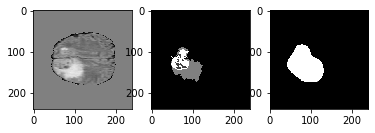

In [496]:
f, axarr = plt.subplots(1,3, fixsize=(240, 240))
axarr[0].imshow(x[0][0])
axarr[1].imshow(y[0][0])
axarr[2].imshow(pred[0][0])



In [3]:
model_15 = keras.models.load_model("../models/model_catCrossentropy_earlyStopping_e15.h5")

In [23]:
x, y = gen.__getitem__(random.randint(0, 10))
pred = model_15.predict(x)

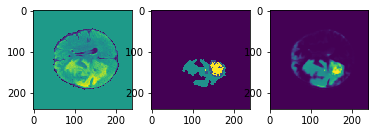

In [24]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(x[0][0])
axarr[1].imshow(y[0][0])
axarr[2].imshow(pred[0][0])